In [13]:
import numpy as np
import pandas as pd
import scipy
import imageio
import math
import phylo as ph

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import warnings
sns.set(style="ticks")
plt.style.use("seaborn-whitegrid")

In [2]:
%load_ext blackcellmagic

# Preparation

All the expensive setup happens up here.

In [3]:
np.random.seed(820)
REGULAR_POKEMON = ph.vectorize_pokemon(ph.REGULAR_POKEMON_PATH)
SHINY_POKEMON = ph.vectorize_pokemon(ph.SHINY_POKEMON_PATH)

Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/regular/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing
Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/shiny/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing


# PCA

Plot high-dimensionality data on two axes.

In [5]:
pca = PCA(n_components=2)
pca.fit(REGULAR_POKEMON)
X = pca.transform(REGULAR_POKEMON)

In [7]:
AV = pca.components_[0]
BV = pca.components_[1]
AV, BV

(array([-4.07752774e-21, -1.74608489e-22, -3.57732205e-25, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([-3.73473906e-16, -2.02151837e-17,  8.19323206e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]))

In [9]:
ddf = pd.DataFrame() 
ddf["a"] = pd.Series([x[0] for x in X])
ddf["b"] = pd.Series([x[1] for x in X])
ddf.head(3)

,a,b
0,18.336314,-26.953641
1,7.734955,-17.403369
2,29.769273,11.090012


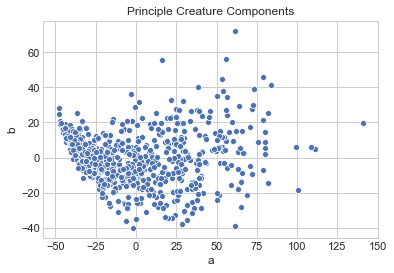

In [12]:
sns.scatterplot(x="a", y="b", data=ddf)
plt.title("Principle Creature Components")
plt.show()

# Clustering

Where do similar vectors fall?

In [58]:
K = 10
kmeans = KMeans(n_clusters=K, random_state=0).fit(REGULAR_POKEMON)
#kmeans.labels_ -> cluster labels for train data
centers = np.uint8(kmeans.cluster_centers_)
centers[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

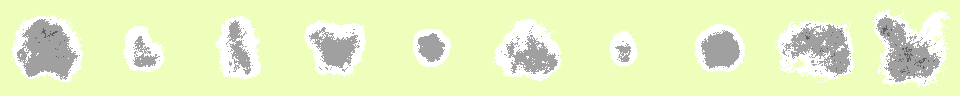

In [59]:
ph.imrow(centers)

In [60]:
ddf["x"] = list(REGULAR_POKEMON)
ddf["cluster"] = kmeans.labels_
ddf[["a", "b", "cluster"]].head(3)

,a,b,cluster
0,18.336314,-26.953641,7
1,7.734955,-17.403369,7
2,29.769273,11.090012,3


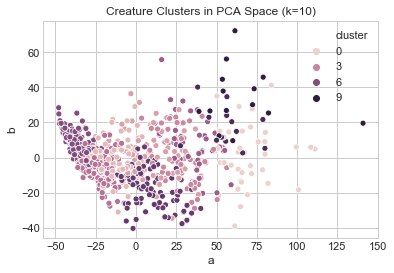

In [61]:
sns.scatterplot(x="a", y="b", hue="cluster", data=ddf)
plt.title("Creature Clusters in PCA Space (k={})".format(K))
plt.show()

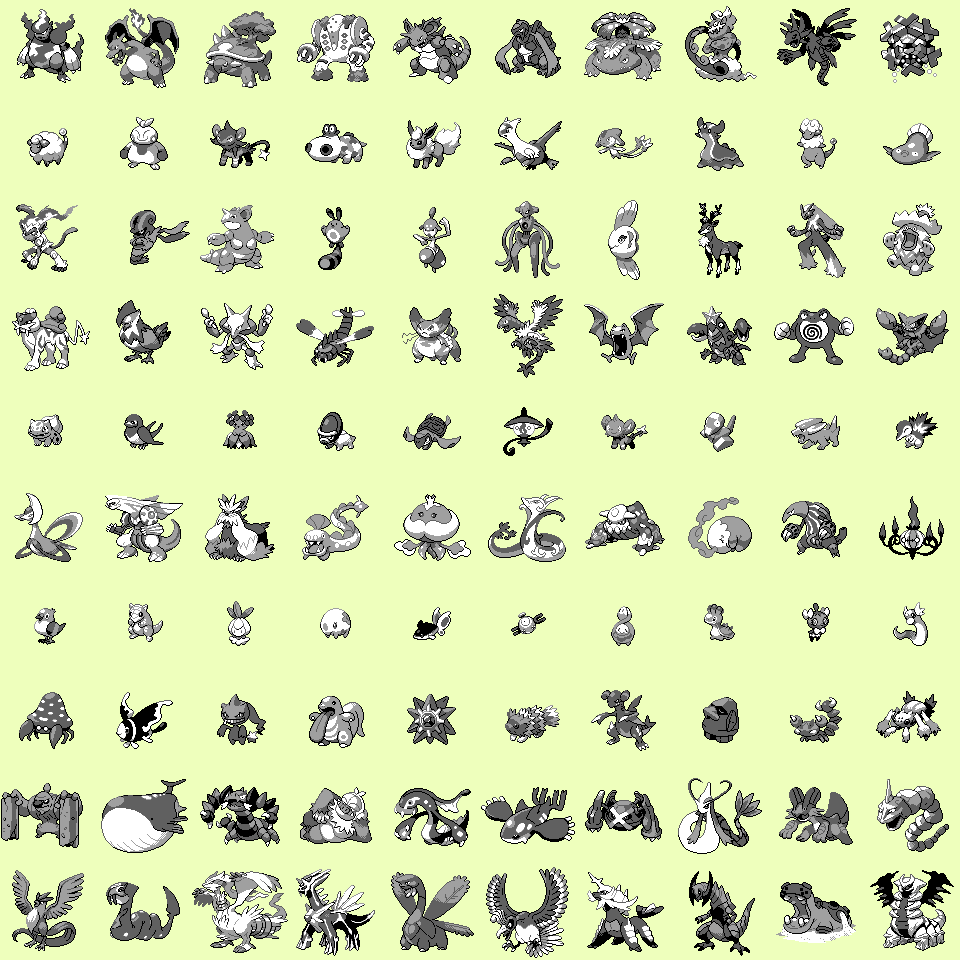

In [62]:
ph.imgrid([ddf.query("cluster == {}".format(k))["x"].head(10) for k in range(K)])

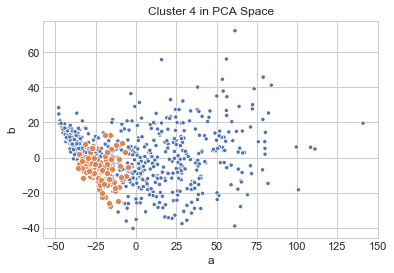

In [94]:
cidx = 4
sns.scatterplot(x="a", y="b", size=0.05, data=ddf)
sns.scatterplot(x="a", y="b", data=ddf.query("cluster == {}".format(cidx)))
plt.title("Cluster {} in PCA Space".format(cidx))
plt.legend().set_visible(False)
plt.show()

In [95]:
kidx = 4
cluster_members = np.array(ddf.query("cluster == {}".format(kidx))["x"])
len(cluster_members)

120

In [98]:
population = ph.choose_from(cluster_members, 20)

In [99]:
pop_half = math.floor(len(population) / 2)
pop_quart = math.floor(pop_half / 2)
xc_mean = math.floor(ph.M / 2)
yc_mean = math.floor(ph.M / 2)
coord_s = 10
radius_mean = 4
radius_s = 2
t = 0
max_turns = 5
scores = []
generations = []
while t < max_turns:
    # Mating
    new_pop = []
    mate_idxs = np.random.choice(range(len(population)), len(population), replace=False)
    for m in range(pop_quart):
        p1 = population[mate_idxs[m*2]]
        p2 = population[mate_idxs[(m*2) + 1]]
        xc = math.floor(ph.draw_normal(xc_mean, coord_s))
        yc = math.floor(ph.draw_normal(yc_mean, coord_s))
        radius = math.floor(ph.draw_normal(radius_mean, radius_s))
        c1, c2 = ph.crossover(p1, p2, xc, yc, radius)
        # new_pop.append(p1)
        # new_pop.append(p2)
        new_pop.append(c1)
        new_pop.append(c2)
        l1 = ph.smooth_quanta(c1, "mid", 0.5)
        l2 = ph.smooth_quanta(c2, "mid", 0.5)
        new_pop.append(l1)
        new_pop.append(l2)
        # new_pop.append(mutate_form(c1, p1))
        # new_pop.append(mutate_form(c2, p2))
    # Updating
    population = new_pop
    generations.append(population)
    scores.append(max([ph.fitness(pv) for pv in population]))
    print("Completed Turn {}".format(t))
    t += 1
print("Done.")

Completed Turn 0
Completed Turn 1
Completed Turn 2
Completed Turn 3
Completed Turn 4
Done.


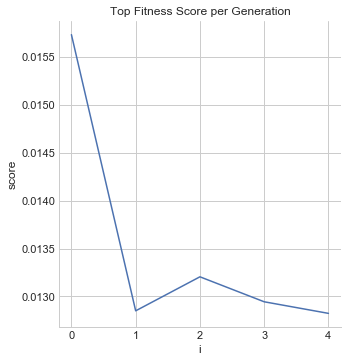

In [100]:
sdf = pd.DataFrame()
sdf["i"] = range(len(scores))
sdf["score"] = scores
sns.relplot(x="i", y="score", kind="line", data=sdf)
plt.title("Top Fitness Score per Generation")
plt.xticks(range(0, t))
plt.show()

In [101]:
best_gen = 4
rdf = ph.rank_generation(generations[best_gen])

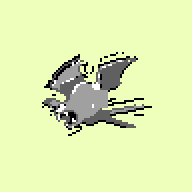

In [102]:
ph.showim(rdf["x"][0], scale=2)

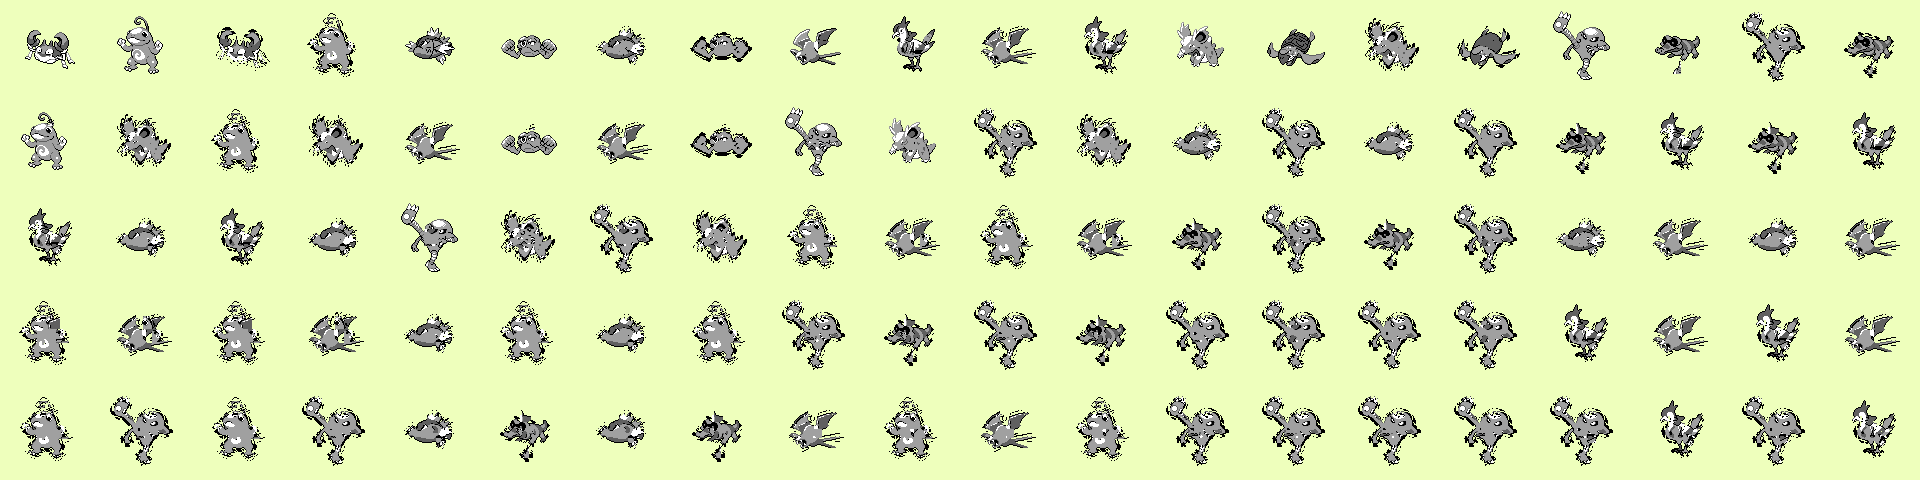

In [103]:
ph.imgrid(generations)